<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

Мы имеем исторические данные о заказах такси в аэропортах.
Нам необходимо спрогнозировать количество заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.


- Значение метрики **RMSE** на тестовой выборке должно быть не больше **48**
- Количество заказов находится в столбце **'num_orders' (от англ. number of orders, «число заказов»)**

# Подготовка

In [1]:
#импортируем нужные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import os

!pip install plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "svg"
svg_renderer = pio.renderers["svg"]
svg_renderer.scale = 1.2
import requests
!pip install cufflinks
import cufflinks as cf
cf.go_offline()
cf.set_config_file(world_readable=True, theme='pearl', offline=True)



#стат блок
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

!pip install prophet
from prophet import Prophet

#настройки
pd.set_option("display.max_rows", 10000)
pd.set_option('max_colwidth', 10000)
pd.set_option('display.width', 500)
pd.set_option("display.float_format", "{:,.2f}".format)
sns.set(style="whitegrid", palette="Pastel1")


import warnings
warnings.filterwarnings('ignore')


from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import (
                ElasticNet,
                Ridge,
                Lasso
)
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import (
                Pipeline, 
                make_pipeline
)

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import ( 
                TimeSeriesSplit,
                train_test_split,
                GridSearchCV,
                cross_val_score
)
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
)


RANDOM_STATE = 42

C:\Users\390\anaconda3\envs\ds_practicum_env\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
try:
    taxi = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
except FileNotFoundError:
    taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
#оставим копию на всякий случай
try:
    df = pd.read_csv('taxi.csv')
except FileNotFoundError:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [4]:
taxi.columns

Index(['num_orders'], dtype='object')

In [5]:
#функция для быстрого просмотра данных
def information(df: 'DataFrame', name: 'str') -> None:
    print('*'*30,name,'*'*30)
    print()
    display(df.head(3))
    print('-'*25,'INFO','-'*25)
    print()
    display(df.info())
    print()
    print('-'*10,'NAN','-'*10)
    print()
    display(df.isna().sum())
    display(pd.DataFrame(round(df.isna().mean()*100,1)).sort_values(by=0, ascending=False).style.background_gradient('coolwarm'))
    print()
    print('-'*5,'DESCRIBE','-'*5)
    display(df.describe())
    print()
    print('-'*5,'DUPLICATED','-'*5)
    display(df.duplicated().sum())
    print()
    print('-'*25,'UNIQUE VALUES','-'*25)
    for column in df.columns:
        display(column)
        display(len(df[column].unique()))
        print('+'*25)
    print("-"*100)

In [6]:
information(taxi, 'Такси')

****************************** Такси ******************************



num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28

------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


---------- NAN ----------



num_orders    0
dtype: int64


----- DESCRIBE -----


num_orders
count   26,496.00
mean        14.07
std          9.21
min          0.00
25%          8.00
50%         13.00
75%         19.00
max        119.00


----- DUPLICATED -----


26415


------------------------- UNIQUE VALUES -------------------------


'num_orders'

81

+++++++++++++++++++++++++
----------------------------------------------------------------------------------------------------


### Вывод:

Итак, данные выгружены:
- Выполнили чтение файла с разпознованием даты, дату поставили в индекс
- Мы имеем **26496** наблюдений
- В **datetime** имеем интервалы в **10 минут**
- Максимальное количество заказов **119** скорее всего выбросы, нужно исследовать наш таргет


# Анализ

Проверим, все ли индексы у нас уникальны.

In [7]:
print('Все индексы уникальны -', taxi.index.is_unique)

Все индексы уникальны - True


In [8]:
taxi.shape[0]

26496

Проверим последовательность индексов.

In [9]:
print('Индексы отсортированы в порядке возрастания -', taxi.index.is_monotonic)

Индексы отсортированы в порядке возрастания - True


In [10]:
#делаем ресэмплинг по 1 часу
taxi = taxi.resample('1H').sum()

In [11]:
taxi.shape[0]

4416

In [12]:
display(taxi.index.max())
display(taxi.index.min())

Timestamp('2018-08-31 23:00:00', freq='H')

Timestamp('2018-03-01 00:00:00', freq='H')

Наблюдения у нас с **1 марта 2018 года по 31 августа 2018 года**

In [13]:
taxi.index.max() - taxi.index.min()

Timedelta('183 days 23:00:00')

Всего **183** дня наблюдений, наблюдения производились с 00:00:00 по  23:00:00

**Посмотрим интерактивный график заказов по нашему датасету**

In [14]:
#функция для просмотра интерактивного графика по датасету
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)
    
%pylab inline    

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [15]:
plotly_df(taxi, title='Число заказов')

Посмотрим на распределение нашего таргета:

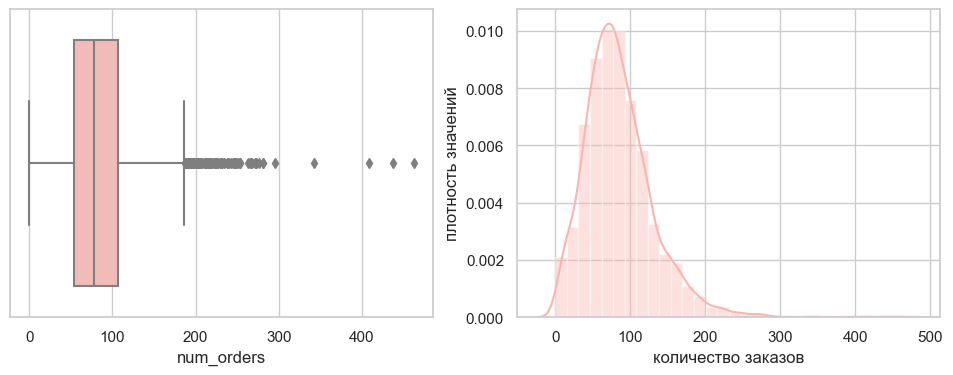

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12,4))
sns.boxplot(taxi['num_orders'], ax=axs[0])
sns.distplot(taxi['num_orders'], ax=axs[1], bins=30, rug=False)
plt.ylabel('плотность значений')
plt.xlabel('количество заказов');

In [17]:
taxi['num_orders'].quantile([0.0, 0.01, 0.02, 0.05, 0.1, 0.25, .5, .65, .75, .85, .93, .97, .99, 1]).transpose()

0.00     0.00
0.01     7.00
0.02    11.30
0.05    21.00
0.10    34.00
0.25    54.00
0.50    78.00
0.65    94.00
0.75   107.00
0.85   126.00
0.93   156.00
0.97   184.00
0.99   223.00
1.00   462.00
Name: num_orders, dtype: float64

По распределению значений можем наблюдать выбросы примерно после **184** заказов, но так как подробностей нам не узнать, будем исследовать данные. Видим, что частота значений начиная от **184** и заканчивая **290** заказами имеет плюс минус плотное распределение. Посмторим на цифры выше **300** особенно даты в эти заказы.

In [18]:
taxi.query('num_orders >=300')

num_orders
datetime                       
2018-08-13 02:00:00         437
2018-08-20 02:00:00         462
2018-08-27 02:00:00         408
2018-08-30 17:00:00         342

Интересно, что выбросы свыше **300** заказов были в основном в августе по понедельникам в **02:00**, вероятнее всего возвращающиеся с отпусков, так как в ночь с вскр на пнд, и один из дней четверг **30 августа** в час пик в **17:00**  это скорее всего суматоха родителей перед началом учебного года у школьников. Исходя иза этих данных можно сделать выводы, какие признаки создавать для модели: можно взять **день недели** и **время суток**

### Посмотрим на общую картину нашего временного ряда

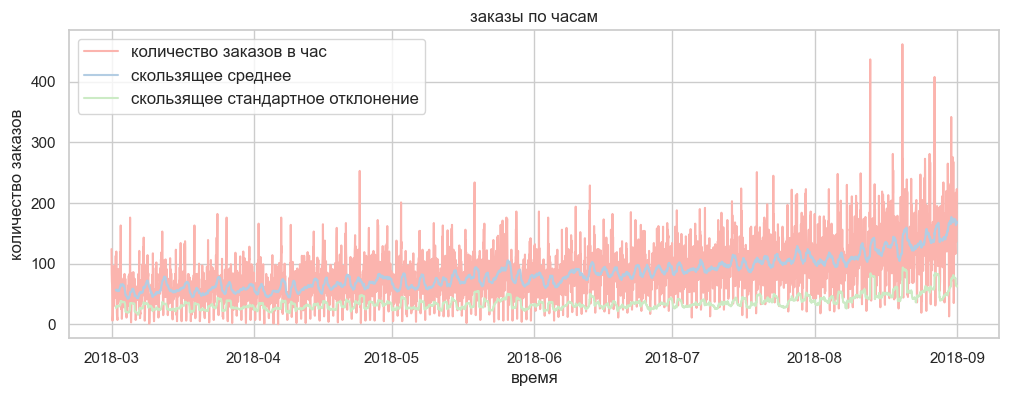

In [19]:
# построим график временного ряда
plt.figure(figsize=(12, 4))
plt.plot(taxi, label = 'количество заказов в час')
plt.plot(taxi.rolling(24).mean(), label = 'скользящее среднее')
plt.plot(taxi.rolling(24).std(), label = 'скользящее стандартное отклонение')

plt.legend(title='', loc='upper left', fontsize=12)
plt.xlabel('время')
plt.ylabel('количество заказов')
plt.title('заказы по часам')
plt.show;

- Как видим тренд на повышение идет с начала **апреля** и до конца наблюдений
- Видны переодичные всплески по месяцам, можно увидеть что в конце **апреля** есть большой всплеск, в **мае**, а также большее количество всплесков наблюдаем в **августе**

### Визуализируем данные по составляющим. Проанализируем их по последнему месяцу наблюдений - август 2018.

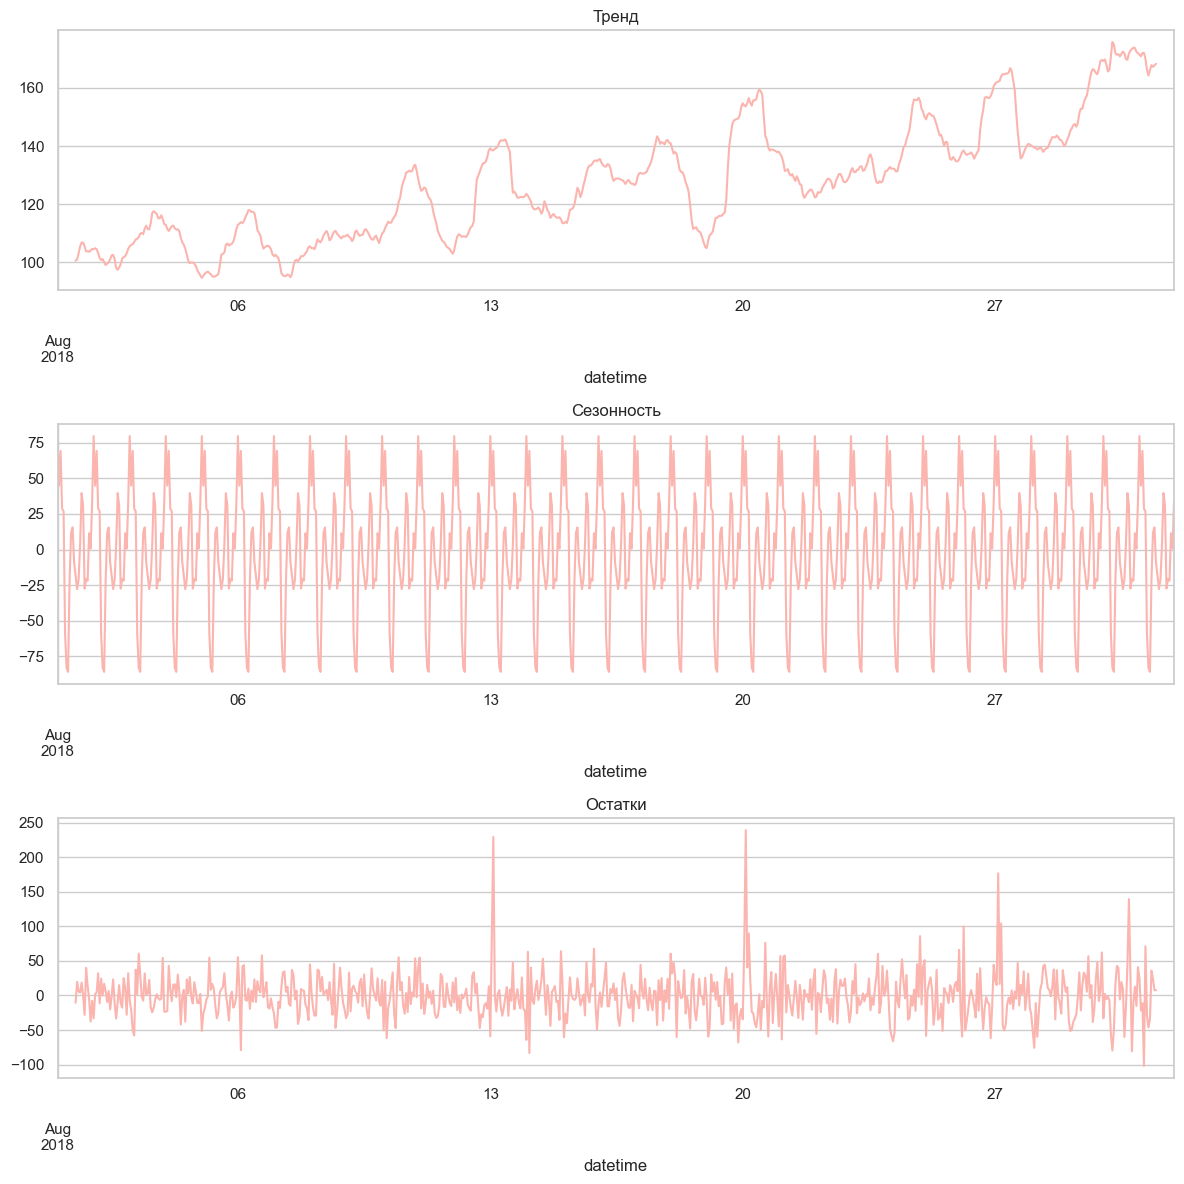

In [20]:
decomposed = seasonal_decompose(taxi['2018-08-01':'2018-08-31'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

- Тренд имеет рост на протяжении всего месяца, очень хорошо видно наши пики - **13, 20, 27 и 30 августа**
- Чтобы понять как влияет сезонность нужно сделать визуализацию автокорреляции
- Остатки тоже имеют переодические всплески как раз в те же дни что и у тренда

### Посмотрим на сезонность и тренд по всему датасету 

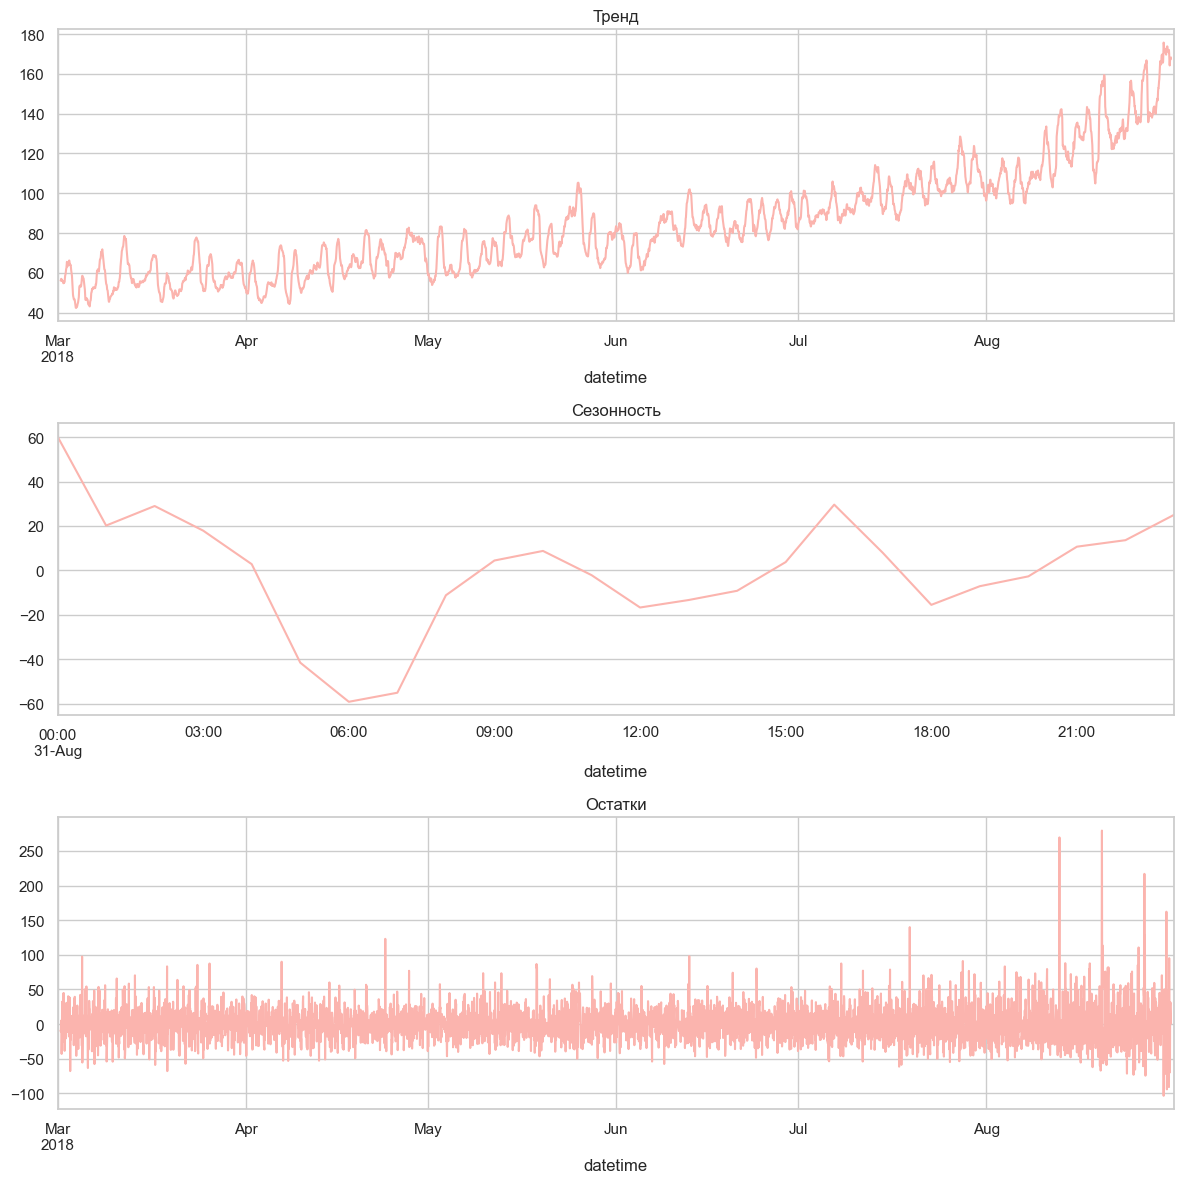

In [21]:
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)

#посмотрим на дневную сезонность
decomposed.seasonal.tail(24).plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

### Проведем стат тест **Dickey-Fuller** (Дики-Фуллера) на стационарность ряда и визуализируем наши данные в автокорреляции по часам

**Сформулируем гипотезы:**

- **H0:** Временной ряд является нестационарным. Другими словами, он имеет некоторую структуру, зависящую от времени, и не имеет постоянной дисперсии во времени.

- **H1:** Временной ряд является стационарным.

- Установим **α = 0.01 (1%)**



Критерий Дики-Фуллера: p=0.028940
H0 подтвердилась, временной ряд имеет единичные корни, ряд не стационарен


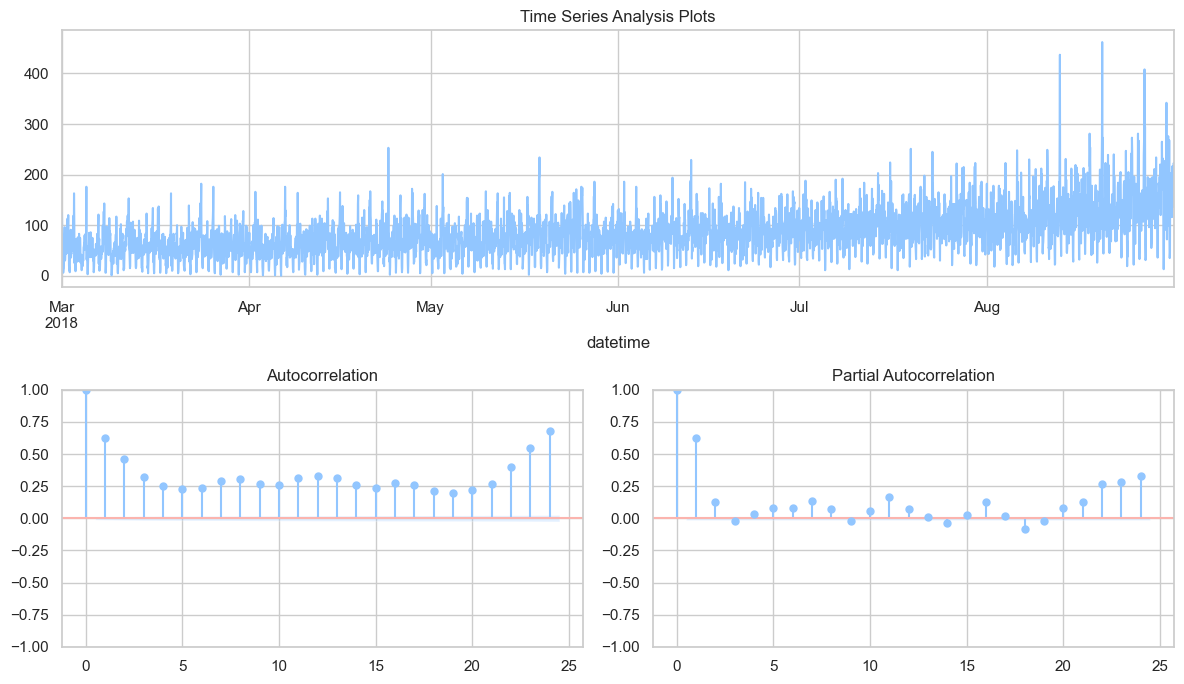

In [22]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context("seaborn-pastel"):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        α = 0.01

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        if sm.tsa.stattools.adfuller(y)[1] > 0.01:
            print("H0 подтвердилась, временной ряд имеет единичные корни, ряд не стационарен")
        else:
            print("отвергаем H0, временной ряд не имеет единичных корней , ряд стационарен") 

        plt.tight_layout()
    return 

tsplot(taxi['num_orders'], lags=24)

Как мы можем наблюдать, при установке значимости **α = 0.01 (1%)** у нас ряд **не стационарен**, однако, если установить уровень значимости **α = 0.05 (5%)** ряд будет **стационарным**.

Но так как мы всегда полагаемся на данные и наши исследования (мы наблюдаем рост заказов в тренде, причем зависимость не линейная а скорее квадратичная, плюс наблюдается наличие сезонности, отчетливо видна **дневная** сезонность), устанавливаем значение **α** строже, так как понимая нашу задачу прогнозирования заказов, этот фактор имеет очень важную составляющую. Прогнозировать на нестационарном ряду сложнее, чем на стационарном. Иначе говоря, нам предстоит строить прогнозирование сравнивая исходный датасет. 

По графику автокорреляции можем наблюдать пики начиная с **00:00 часов и заканчивая 3 часами ночи**, далее **с 22 часов и до 00:00** так же.


In [23]:
taxi.shape[0]

4416

### Создадим признаки с помощью Prophet

In [24]:
predictions = 24*4

train_df = taxi[:-predictions]
train_df.reset_index(inplace=True)
train_df.columns = ['ds', 'y']
taxi.columns = ['y']
train_df.tail()

# Python
m = Prophet(changepoint_prior_scale=0.10, seasonality_prior_scale=10.00, holidays_prior_scale=0.01,
            seasonality_mode= 'additive')
m.fit(train_df);

future = m.make_future_dataframe(periods=predictions, freq='1H')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

15:35:20 - cmdstanpy - INFO - Chain [1] start processing
15:35:20 - cmdstanpy - INFO - Chain [1] done processing


ds   yhat  yhat_lower  yhat_upper
4411 2018-08-31 19:00:00 141.85      107.27      175.31
4412 2018-08-31 20:00:00 148.66      113.00      182.78
4413 2018-08-31 21:00:00 163.98      135.14      199.98
4414 2018-08-31 22:00:00 177.79      143.52      211.02
4415 2018-08-31 23:00:00 185.04      151.07      218.25

In [25]:
forecast.shape[0]

4416

In [26]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, daily, daily_lower, daily_upper, weekly, weekly_lower, weekly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


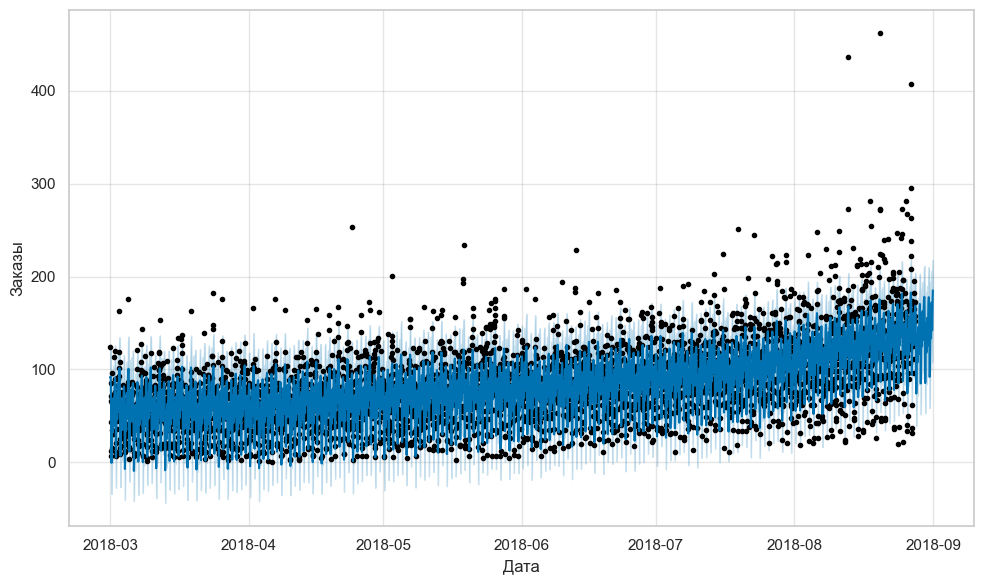

In [27]:
m.plot(forecast)
plt.xlabel('Дата')
plt.ylabel('Заказы');

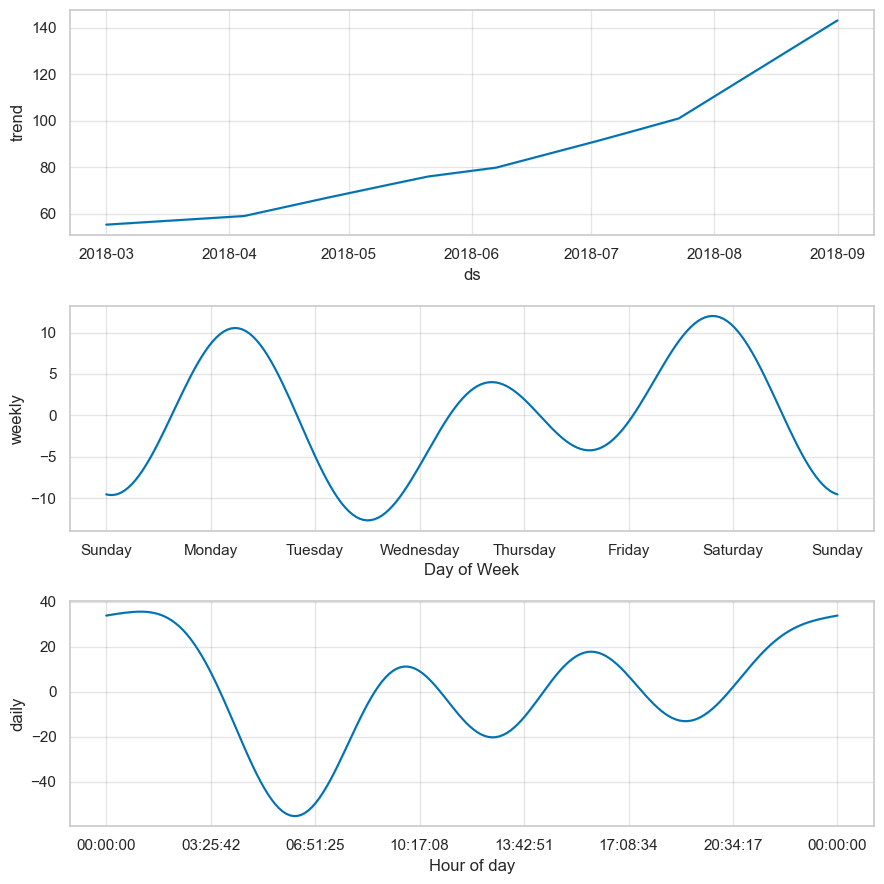

In [28]:
m.plot_components(forecast);

**Посмотрим на интерактивный график прогноза заказов**

In [29]:
cmp_df = forecast.set_index('ds')[['yhat', 'trend','additive_terms', 'yhat_lower', 'yhat_upper', 'trend_lower',
                                   'trend_upper',  'additive_terms', 'additive_terms_lower',
                                   'additive_terms_upper', 'daily', 'weekly']].join(taxi)

In [30]:
#функция для визуализации построенного прогноза
def show_forecast(df, num_predictions, num_values):
    #верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=df.tail(num_predictions).index,
        y=df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="#444"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    #прогноз
    forecast = go.Scatter(
        name='Prediction',
        x=df.tail(predictions).index,
        y=df.tail(predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    #нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=df.tail(num_predictions).index,
        y=df.tail(num_predictions).yhat_lower,
        marker=dict(color="#444"),
        line=dict(width=0),
        mode='lines')

    #фактические значения
    fact = go.Scatter(
        name='Fact',
        x=df.tail(num_values).index,
        y=df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    #последовательность рядов в данном случае важна из-за применения заливки
    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title='Количество заказов'),
        title='Заказы такси: прогноз',
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(round(cmp_df), predictions, 200)

**Мы можем наблюдать что переломные пики предсказать очень трудно**

In [31]:
cmp_df.isna().sum()

yhat                    0
trend                   0
additive_terms          0
yhat_lower              0
yhat_upper              0
trend_lower             0
trend_upper             0
additive_terms          0
additive_terms_lower    0
additive_terms_upper    0
daily                   0
weekly                  0
y                       0
dtype: int64

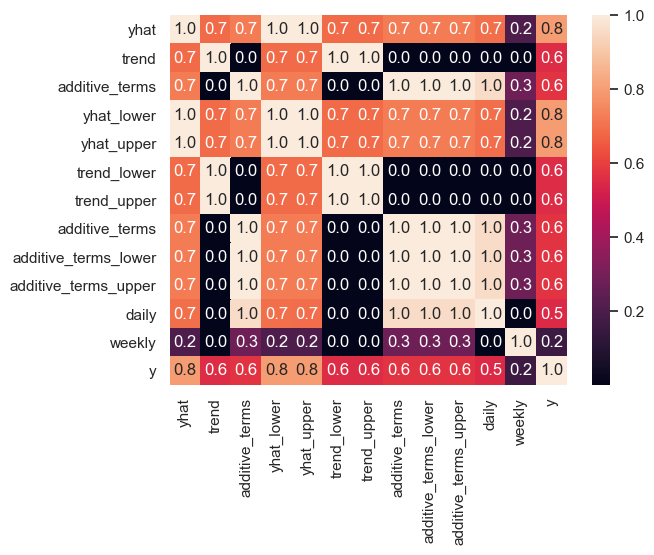

In [32]:
sns.heatmap(data=cmp_df.corr(), annot=True, fmt='.1f');

# Обучение

In [33]:
train, test = train_test_split(cmp_df, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)
train = train.dropna()
test = test.dropna()
X_train = train.drop(['y'], axis=1)
X_test = test.drop(['y'], axis=1)
y_train = train['y']
y_test = test['y']
print(f"  Train: size={train.shape[0]}")
print(f"  Test:  size={test.shape[0]}")

  Train: size=3974
  Test:  size=442


In [34]:
X_train

yhat  trend  additive_terms  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  daily  weekly
ds                                                                                                                                                                            
2018-03-01 00:00:00  91.07  55.22           35.85       57.67      125.11        55.22        55.22           35.85                 35.85                 35.85  33.91    1.94
2018-03-01 01:00:00  92.26  55.22           37.04       59.12      126.72        55.22        55.22           37.04                 37.04                 37.04  35.61    1.43
2018-03-01 02:00:00  89.06  55.23           33.84       55.17      123.43        55.23        55.23           33.84                 33.84                 33.84  32.95    0.89
2018-03-01 03:00:00  74.58  55.23           19.35       39.52      107.95        55.23        55.23           19.35                 19.35                 19.35  19.02    0.33
2018-03-01 04:00:00  47.02  55.24           -8.22       16.42       80.94        55.24        55.24           -8.22                 -8.22                 -8.22  -7.98   -0.24
2018-03-01 05:00:00  16.22  55.24          -39.02      -17.66       53.02        55.24        55.24          -39.02                -39.02                -39.02 -38.21   -0.81
2018-03-01 06:00:00  -0.89  55.25          -56.14      -34.31       34.37        55.25        55.25          -56.14                -56.14                -56.14 -54.78   -1.36
2018-03-01 07:00:00   6.21  55.25          -49.04      -26.74       39.03        55.25        55.25          -49.04                -49.04                -49.04 -47.15   -1.89
2018-03-01 08:00:00  31.56  55.25          -23.70       -5.03       64.42        55.25        55.25          -23.70                -23.70                -23.70 -21.31   -2.39
2018-03-01 09:00:00  56.11  55.26            0.85       21.80       88.95        55.26        55.26            0.85                  0.85                  0.85   3.69   -2.84
2018-03-01 10:00:00  62.98  55.26            7.72       30.46       97.94        55.26        55.26            7.72                  7.72                  7.72  10.96   -3.24
2018-03-01 11:00:00  51.15  55.27           -4.11       16.29       83.04        55.27        55.27           -4.11                 -4.11                 -4.11  -0.53   -3.59
2018-03-01 12:00:00  35.27  55.27          -20.00       -0.46       69.84        55.27        55.27          -20.00                -20.00                -20.00 -16.14   -3.86
2018-03-01 13:00:00  31.87  55.28          -23.40       -1.16       68.03        55.28        55.28          -23.40                -23.40                -23.40 -19.34   -4.07
2018-03-01 14:00:00  44.63  55.28          -10.65       10.05       75.54        55.28        55.28          -10.65                -10.65                -10.65  -6.46   -4.19
2018-03-01 15:00:00  62.04  55.28            6.76       25.59       96.28        55.28        55.28            6.76                  6.76                  6.76  10.99   -4.23
2018-03-01 16:00:00  68.89  55.29           13.60       35.20      103.44        55.29        55.29           13.60                 13.60                 13.60  17.79   -4.19
2018-03-01 17:00:00  60.35  55.29            5.06       25.84       93.20        55.29        55.29            5.06                  5.06                  5.06   9.11   -4.06
2018-03-01 18:00:00  45.63  55.30           -9.67       11.83       79.78        55.30        55.30           -9.67                 -9.67                 -9.67  -5.83   -3.84
2018-03-01 19:00:00  38.72  55.30          -16.58        3.42       72.62        55.30        55.30          -16.58                -16.58                -16.58 -13.05   -3.53
2018-03-01 20:00:00  45.90  55.31           -9.40       12.31       81.07        55.31        55.31           -9.40                 -9.40                 -9.40  -6.27   -3.

In [35]:
X_test

yhat  trend  additive_terms  yhat_lower  yhat_upper  trend_lower  trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  daily  weekly
ds                                                                                                                                                                            
2018-08-13 14:00:00 123.62 123.67           -0.04       90.47      157.11       123.67       123.67           -0.04                 -0.04                 -0.04  -6.46    6.41
2018-08-13 15:00:00 140.14 123.71           16.43      105.45      174.54       123.71       123.71           16.43                 16.43                 16.43  10.99    5.44
2018-08-13 16:00:00 145.95 123.75           22.19      112.56      181.52       123.75       123.75           22.19                 22.19                 22.19  17.79    4.41
2018-08-13 17:00:00 136.22 123.80           12.42      103.16      169.60       123.80       123.80           12.42                 12.42                 12.42   9.11    3.31
2018-08-13 18:00:00 120.18 123.84           -3.66       86.85      153.67       123.84       123.84           -3.66                 -3.66                 -3.66  -5.83    2.17
2018-08-13 19:00:00 111.83 123.89          -12.06       75.17      146.30       123.89       123.89          -12.06                -12.06                -12.06 -13.05    0.99
2018-08-13 20:00:00 117.45 123.93           -6.48       84.15      152.52       123.93       123.93           -6.48                 -6.48                 -6.48  -6.27   -0.21
2018-08-13 21:00:00 131.70 123.97            7.73       96.00      164.15       123.97       123.97            7.73                  7.73                  7.73   9.14   -1.41
2018-08-13 22:00:00 144.56 124.02           20.54      112.47      177.99       124.02       124.02           20.54                 20.54                 20.54  23.15   -2.61
2018-08-13 23:00:00 150.98 124.06           26.92      115.26      185.90       124.06       124.06           26.92                 26.92                 26.92  30.71   -3.80
2018-08-14 00:00:00 153.06 124.11           28.96      122.31      185.57       124.11       124.11           28.96                 28.96                 28.96  33.91   -4.95
2018-08-14 01:00:00 153.70 124.15           29.55      120.47      186.33       124.15       124.15           29.55                 29.55                 29.55  35.61   -6.06
2018-08-14 02:00:00 150.03 124.19           25.84      116.74      182.71       124.19       124.19           25.84                 25.84                 25.84  32.95   -7.11
2018-08-14 03:00:00 135.16 124.24           10.92      102.94      168.09       124.24       124.24           10.92                 10.92                 10.92  19.02   -8.10
2018-08-14 04:00:00 107.29 124.28          -16.99       74.24      143.41       124.28       124.28          -16.99                -16.99                -16.99  -7.98   -9.01
2018-08-14 05:00:00  76.28 124.33          -48.05       41.59      110.01       124.33       124.33          -48.05                -48.05                -48.05 -38.21   -9.84
2018-08-14 06:00:00  59.02 124.37          -65.35       27.45       93.48       124.37       124.37          -65.35                -65.35                -65.35 -54.78  -10.57
2018-08-14 07:00:00  66.06 124.41          -58.35       30.99       97.95       124.41       124.41          -58.35                -58.35                -58.35 -47.15  -11.20
2018-08-14 08:00:00  91.42 124.46          -33.04       56.85      124.45       124.46       124.46          -33.04                -33.04                -33.04 -21.31  -11.73
2018-08-14 09:00:00 116.05 124.50           -8.45       82.39      149.60       124.50       124.50           -8.45                 -8.45                 -8.45   3.69  -12.14
2018-08-14 10:00:00 123.07 124.55           -1.48       90.70      156.00       124.55       124.55           -1.48                 -1.48                 -1.48  10.96  -12.

In [36]:
pipeline = Pipeline(steps=[('scaler', RobustScaler())])
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [37]:
split = TimeSeriesSplit(n_splits=3)

In [38]:
#функция для кросс валидации (подбора модели без гиперпараметров)
def cross_val(model):
    cvs = cross_val_score(model, X_train, y_train, cv=split,
                          scoring='neg_root_mean_squared_error', n_jobs=-1).mean()
    return print("Лучшее значение",  model,  "на кросс валидации:", -cvs)

In [39]:
cross_val(Lasso(random_state=RANDOM_STATE))

Лучшее значение Lasso(random_state=42) на кросс валидации: 27.012812441186743


In [40]:
cross_val(ElasticNet(random_state=RANDOM_STATE))

Лучшее значение ElasticNet(random_state=42) на кросс валидации: 28.889626319872207


In [41]:
cross_val(Ridge(random_state=RANDOM_STATE))

Лучшее значение Ridge(random_state=42) на кросс валидации: 25.90998869180005


In [42]:
cross_val(LGBMRegressor(random_state=RANDOM_STATE))

Лучшее значение LGBMRegressor(random_state=42) на кросс валидации: 26.065195258671782


In [43]:
cross_val(CatBoostRegressor(random_state=RANDOM_STATE))

Лучшее значение <catboost.core.CatBoostRegressor object at 0x000001FB825D81F0> на кросс валидации: 25.31519695648245


**По итогам кросс валидации у нас лидируют Ridge, LGBM и CatBoost**

In [44]:
%%time
rg = Pipeline(steps=[('regressor', Ridge(random_state=RANDOM_STATE))])


#задаем параметры для grid search
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1]
}

#создаем объект GridSearchCV
s_rg = GridSearchCV(rg, param_grid=param_grid, cv=split,
                      scoring='neg_root_mean_squared_error',
                      refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_rg.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_rg.best_params_)
print("Лучшее значение: ", -s_rg.best_score_)

Лучшие параметры:  {'regressor__alpha': 0.001}
Лучшее значение:  25.876069830803043
CPU times: total: 46.9 ms
Wall time: 63 ms


In [45]:
%%time
lgbm = Pipeline(steps=[('regressor', LGBMRegressor(random_state=RANDOM_STATE))])


#задаем параметры для grid search
param_grid = {
    'regressor__learning_rate': [0.1, 0.2],
    'regressor__n_estimators' : range(100, 400, 50),
    'regressor__max_depth' : range(10, 16 , 5),
}

#создаем объект GridSearchCV
s_lgbm = GridSearchCV(lgbm, param_grid=param_grid, cv=split,
                      scoring='neg_root_mean_squared_error',
                      refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_lgbm.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_lgbm.best_params_)
print("Лучшее значение: ", -s_lgbm.best_score_)

Лучшие параметры:  {'regressor__learning_rate': 0.1, 'regressor__max_depth': 15, 'regressor__n_estimators': 150}
Лучшее значение:  25.937790819363112
CPU times: total: 1.84 s
Wall time: 8.41 s


In [46]:
%%time
cb = Pipeline(steps=[('regressor', CatBoostRegressor(random_state=RANDOM_STATE))])
param_grid = {
    'regressor__learning_rate': [0.1, 0.3, 0.01],
    'regressor__n_estimators': range(100, 301, 100),
}

#создаем объект GridSearchCV
s_cb = GridSearchCV(cb, param_grid=param_grid, cv=split,
                    scoring='neg_root_mean_squared_error', refit=True, error_score='raise', n_jobs=-1)

#обучаем модель на тренировочных данных
s_cb.fit(X_train, y_train)

#выводим лучшие параметры и результаты кросс-валидации
print("Лучшие параметры: ", s_cb.best_params_)
print("Лучшее значение: ", -s_cb.best_score_)

0:	learn: 36.6229443	total: 159ms	remaining: 47.4s
1:	learn: 34.8406643	total: 163ms	remaining: 24.3s
2:	learn: 33.2448767	total: 166ms	remaining: 16.5s
3:	learn: 31.8192138	total: 174ms	remaining: 12.8s
4:	learn: 30.6630356	total: 177ms	remaining: 10.4s
5:	learn: 29.6234401	total: 179ms	remaining: 8.79s
6:	learn: 28.6705788	total: 183ms	remaining: 7.64s
7:	learn: 27.8814276	total: 189ms	remaining: 6.89s
8:	learn: 27.2430314	total: 192ms	remaining: 6.22s
9:	learn: 26.6622461	total: 195ms	remaining: 5.66s
10:	learn: 26.2304332	total: 198ms	remaining: 5.21s
11:	learn: 25.8184795	total: 203ms	remaining: 4.88s
12:	learn: 25.4838071	total: 207ms	remaining: 4.56s
13:	learn: 25.1899292	total: 210ms	remaining: 4.28s
14:	learn: 24.8337685	total: 213ms	remaining: 4.04s
15:	learn: 24.5345753	total: 217ms	remaining: 3.85s
16:	learn: 24.3234121	total: 221ms	remaining: 3.68s
17:	learn: 24.1805112	total: 225ms	remaining: 3.52s
18:	learn: 24.0378029	total: 228ms	remaining: 3.37s
19:	learn: 23.9024858	

174:	learn: 17.9643062	total: 746ms	remaining: 533ms
175:	learn: 17.9259986	total: 749ms	remaining: 528ms
176:	learn: 17.9080086	total: 753ms	remaining: 523ms
177:	learn: 17.8876907	total: 756ms	remaining: 518ms
178:	learn: 17.8748037	total: 759ms	remaining: 513ms
179:	learn: 17.8580718	total: 762ms	remaining: 508ms
180:	learn: 17.8289144	total: 765ms	remaining: 503ms
181:	learn: 17.8087264	total: 769ms	remaining: 499ms
182:	learn: 17.7893120	total: 772ms	remaining: 493ms
183:	learn: 17.7801770	total: 775ms	remaining: 488ms
184:	learn: 17.7731764	total: 778ms	remaining: 484ms
185:	learn: 17.7406602	total: 781ms	remaining: 479ms
186:	learn: 17.7313720	total: 784ms	remaining: 474ms
187:	learn: 17.7100189	total: 788ms	remaining: 469ms
188:	learn: 17.6841558	total: 791ms	remaining: 464ms
189:	learn: 17.6640774	total: 794ms	remaining: 460ms
190:	learn: 17.6572959	total: 797ms	remaining: 455ms
191:	learn: 17.6511822	total: 800ms	remaining: 450ms
192:	learn: 17.6260278	total: 803ms	remaining:

**Так как все три модели показывают впринципе неплохой результат, я склоняюсь сделать bagging для двух моделей-Ridge(линейная) так как мы знаем, что линейные модели хорошо экстраполируют, чтобы строить прогноз не только на ближайший час, а видеть тренды, по месяцам..., и CatBoost так как у этой модели вшиты хорошие параметры для предотвращения переобучения**

In [47]:
#создаем базовые модели
catboost = s_cb.best_estimator_
ridge = s_rg.best_estimator_

#создаем бэггинг-модель, используя базовые модели
bagging = BaggingRegressor(base_estimator=catboost, n_estimators=6, random_state=RANDOM_STATE)

pipeline = Pipeline([('bagging', bagging)
])


param_grid = { }

#создаем объект GridSearchCV
search_bagging = GridSearchCV(pipeline, param_grid=param_grid, cv=split,
                              scoring='neg_root_mean_squared_error', n_jobs=-1, refit=True)

#обучаем модель на тренировочных данных
search_bagging.fit(X_train, y_train)

#выводим результаты кросс-валидации
print("Best cross-validation score: ", -search_bagging.best_score_)


0:	learn: 36.6982918	total: 3.21ms	remaining: 961ms
1:	learn: 34.8454877	total: 6.38ms	remaining: 950ms
2:	learn: 33.2006729	total: 9.2ms	remaining: 910ms
3:	learn: 31.7785658	total: 12.1ms	remaining: 892ms
4:	learn: 30.5820475	total: 14.8ms	remaining: 875ms
5:	learn: 29.5202596	total: 17.6ms	remaining: 864ms
6:	learn: 28.5975902	total: 20.5ms	remaining: 858ms
7:	learn: 27.7926304	total: 23.3ms	remaining: 851ms
8:	learn: 27.0708497	total: 26ms	remaining: 842ms
9:	learn: 26.4650601	total: 28.8ms	remaining: 836ms
10:	learn: 25.9800907	total: 31.6ms	remaining: 829ms
11:	learn: 25.5333779	total: 34.4ms	remaining: 826ms
12:	learn: 25.1014005	total: 37.3ms	remaining: 823ms
13:	learn: 24.7877118	total: 40.1ms	remaining: 819ms
14:	learn: 24.4685400	total: 42.8ms	remaining: 813ms
15:	learn: 24.2239047	total: 45.7ms	remaining: 811ms
16:	learn: 23.9899215	total: 48.6ms	remaining: 808ms
17:	learn: 23.7980201	total: 51.7ms	remaining: 811ms
18:	learn: 23.5651075	total: 54.9ms	remaining: 812ms
19:	le

198:	learn: 15.8896044	total: 568ms	remaining: 289ms
199:	learn: 15.8776246	total: 572ms	remaining: 286ms
200:	learn: 15.8514748	total: 575ms	remaining: 283ms
201:	learn: 15.8402858	total: 577ms	remaining: 280ms
202:	learn: 15.8126430	total: 580ms	remaining: 277ms
203:	learn: 15.7780144	total: 583ms	remaining: 274ms
204:	learn: 15.7582923	total: 586ms	remaining: 272ms
205:	learn: 15.7395727	total: 589ms	remaining: 269ms
206:	learn: 15.7223986	total: 592ms	remaining: 266ms
207:	learn: 15.7058098	total: 595ms	remaining: 263ms
208:	learn: 15.6826473	total: 597ms	remaining: 260ms
209:	learn: 15.6582260	total: 600ms	remaining: 257ms
210:	learn: 15.6456590	total: 603ms	remaining: 254ms
211:	learn: 15.6247213	total: 606ms	remaining: 252ms
212:	learn: 15.6023368	total: 609ms	remaining: 249ms
213:	learn: 15.5875406	total: 611ms	remaining: 246ms
214:	learn: 15.5666650	total: 614ms	remaining: 243ms
215:	learn: 15.5466075	total: 617ms	remaining: 240ms
216:	learn: 15.5210361	total: 620ms	remaining:

91:	learn: 19.7633521	total: 261ms	remaining: 590ms
92:	learn: 19.7357877	total: 264ms	remaining: 588ms
93:	learn: 19.7092258	total: 267ms	remaining: 585ms
94:	learn: 19.6450141	total: 270ms	remaining: 582ms
95:	learn: 19.5758975	total: 272ms	remaining: 579ms
96:	learn: 19.5465195	total: 275ms	remaining: 576ms
97:	learn: 19.5081093	total: 278ms	remaining: 573ms
98:	learn: 19.4449593	total: 281ms	remaining: 570ms
99:	learn: 19.3918016	total: 284ms	remaining: 567ms
100:	learn: 19.3301955	total: 286ms	remaining: 564ms
101:	learn: 19.3138072	total: 289ms	remaining: 561ms
102:	learn: 19.2729682	total: 292ms	remaining: 559ms
103:	learn: 19.2327393	total: 295ms	remaining: 556ms
104:	learn: 19.1827992	total: 298ms	remaining: 553ms
105:	learn: 19.1597829	total: 300ms	remaining: 550ms
106:	learn: 19.1329882	total: 303ms	remaining: 547ms
107:	learn: 19.1103396	total: 306ms	remaining: 544ms
108:	learn: 19.0998983	total: 309ms	remaining: 541ms
109:	learn: 19.0633825	total: 312ms	remaining: 538ms
11

280:	learn: 15.0810086	total: 832ms	remaining: 56.2ms
281:	learn: 15.0647156	total: 835ms	remaining: 53.3ms
282:	learn: 15.0453579	total: 838ms	remaining: 50.3ms
283:	learn: 15.0314266	total: 841ms	remaining: 47.4ms
284:	learn: 15.0255846	total: 844ms	remaining: 44.4ms
285:	learn: 15.0104893	total: 848ms	remaining: 41.5ms
286:	learn: 14.9925019	total: 851ms	remaining: 38.5ms
287:	learn: 14.9719020	total: 854ms	remaining: 35.6ms
288:	learn: 14.9506588	total: 857ms	remaining: 32.6ms
289:	learn: 14.9349019	total: 860ms	remaining: 29.7ms
290:	learn: 14.9101937	total: 864ms	remaining: 26.7ms
291:	learn: 14.8852317	total: 866ms	remaining: 23.7ms
292:	learn: 14.8610440	total: 869ms	remaining: 20.8ms
293:	learn: 14.8482650	total: 873ms	remaining: 17.8ms
294:	learn: 14.8354582	total: 876ms	remaining: 14.8ms
295:	learn: 14.8175340	total: 879ms	remaining: 11.9ms
296:	learn: 14.8116318	total: 882ms	remaining: 8.91ms
297:	learn: 14.8000095	total: 885ms	remaining: 5.94ms
298:	learn: 14.7843872	total

148:	learn: 17.6652012	total: 485ms	remaining: 491ms
149:	learn: 17.6251310	total: 488ms	remaining: 488ms
150:	learn: 17.6037370	total: 491ms	remaining: 485ms
151:	learn: 17.5717208	total: 495ms	remaining: 482ms
152:	learn: 17.5584764	total: 498ms	remaining: 479ms
153:	learn: 17.5258811	total: 501ms	remaining: 475ms
154:	learn: 17.4867169	total: 504ms	remaining: 472ms
155:	learn: 17.4612635	total: 507ms	remaining: 468ms
156:	learn: 17.4308989	total: 510ms	remaining: 465ms
157:	learn: 17.4072789	total: 514ms	remaining: 462ms
158:	learn: 17.3908529	total: 517ms	remaining: 458ms
159:	learn: 17.3571716	total: 520ms	remaining: 455ms
160:	learn: 17.3265510	total: 523ms	remaining: 451ms
161:	learn: 17.3029861	total: 526ms	remaining: 448ms
162:	learn: 17.2764424	total: 530ms	remaining: 445ms
163:	learn: 17.2633676	total: 533ms	remaining: 442ms
164:	learn: 17.2459488	total: 536ms	remaining: 439ms
165:	learn: 17.2156591	total: 539ms	remaining: 435ms
166:	learn: 17.1974106	total: 542ms	remaining:

13:	learn: 24.0572174	total: 45.7ms	remaining: 933ms
14:	learn: 23.7812100	total: 49.3ms	remaining: 937ms
15:	learn: 23.5814900	total: 52.5ms	remaining: 931ms
16:	learn: 23.4118036	total: 56ms	remaining: 932ms
17:	learn: 23.1817015	total: 59.2ms	remaining: 928ms
18:	learn: 23.0280424	total: 62.3ms	remaining: 922ms
19:	learn: 22.7984488	total: 65.7ms	remaining: 920ms
20:	learn: 22.6755152	total: 68.9ms	remaining: 915ms
21:	learn: 22.4690093	total: 72.3ms	remaining: 914ms
22:	learn: 22.3465815	total: 75.4ms	remaining: 909ms
23:	learn: 22.2161550	total: 78.6ms	remaining: 903ms
24:	learn: 22.1320548	total: 81.5ms	remaining: 897ms
25:	learn: 22.0125735	total: 84.7ms	remaining: 892ms
26:	learn: 21.8783801	total: 88ms	remaining: 890ms
27:	learn: 21.7845158	total: 91.1ms	remaining: 885ms
28:	learn: 21.6906741	total: 94.5ms	remaining: 883ms
29:	learn: 21.6490704	total: 97.7ms	remaining: 879ms
30:	learn: 21.6039789	total: 101ms	remaining: 879ms
31:	learn: 21.5149946	total: 105ms	remaining: 879ms

189:	learn: 16.3017009	total: 612ms	remaining: 355ms
190:	learn: 16.2726534	total: 616ms	remaining: 352ms
191:	learn: 16.2588504	total: 620ms	remaining: 349ms
192:	learn: 16.2286313	total: 623ms	remaining: 346ms
193:	learn: 16.2095595	total: 627ms	remaining: 342ms
194:	learn: 16.1795796	total: 630ms	remaining: 339ms
195:	learn: 16.1372483	total: 633ms	remaining: 336ms
196:	learn: 16.1111677	total: 637ms	remaining: 333ms
197:	learn: 16.1078906	total: 640ms	remaining: 330ms
198:	learn: 16.0844045	total: 644ms	remaining: 327ms
199:	learn: 16.0475087	total: 647ms	remaining: 323ms
200:	learn: 16.0284519	total: 650ms	remaining: 320ms
201:	learn: 16.0120010	total: 653ms	remaining: 317ms
202:	learn: 15.9903841	total: 657ms	remaining: 314ms
203:	learn: 15.9597468	total: 660ms	remaining: 311ms
204:	learn: 15.9407523	total: 664ms	remaining: 308ms
205:	learn: 15.9134350	total: 667ms	remaining: 304ms
206:	learn: 15.8980697	total: 671ms	remaining: 301ms
207:	learn: 15.8822836	total: 674ms	remaining:

57:	learn: 21.4583205	total: 186ms	remaining: 775ms
58:	learn: 21.4347623	total: 189ms	remaining: 772ms
59:	learn: 21.4202847	total: 192ms	remaining: 769ms
60:	learn: 21.3556703	total: 195ms	remaining: 766ms
61:	learn: 21.3477204	total: 199ms	remaining: 762ms
62:	learn: 21.2684093	total: 202ms	remaining: 759ms
63:	learn: 21.2109308	total: 205ms	remaining: 755ms
64:	learn: 21.1747227	total: 208ms	remaining: 751ms
65:	learn: 21.1678102	total: 210ms	remaining: 745ms
66:	learn: 21.1477783	total: 212ms	remaining: 739ms
67:	learn: 21.1226163	total: 215ms	remaining: 735ms
68:	learn: 21.0905446	total: 219ms	remaining: 732ms
69:	learn: 21.0178647	total: 223ms	remaining: 732ms
70:	learn: 20.9606231	total: 226ms	remaining: 729ms
71:	learn: 20.8865523	total: 229ms	remaining: 726ms
72:	learn: 20.8753429	total: 232ms	remaining: 723ms
73:	learn: 20.8377044	total: 236ms	remaining: 720ms
74:	learn: 20.8166863	total: 239ms	remaining: 716ms
75:	learn: 20.7959616	total: 242ms	remaining: 714ms
76:	learn: 2

237:	learn: 15.8991544	total: 770ms	remaining: 200ms
238:	learn: 15.8851546	total: 773ms	remaining: 197ms
239:	learn: 15.8589930	total: 777ms	remaining: 194ms
240:	learn: 15.8342607	total: 780ms	remaining: 191ms
241:	learn: 15.8050282	total: 783ms	remaining: 188ms
242:	learn: 15.7665603	total: 786ms	remaining: 184ms
243:	learn: 15.7444006	total: 789ms	remaining: 181ms
244:	learn: 15.7142043	total: 792ms	remaining: 178ms
245:	learn: 15.6965898	total: 796ms	remaining: 175ms
246:	learn: 15.6835478	total: 799ms	remaining: 171ms
247:	learn: 15.6560491	total: 802ms	remaining: 168ms
248:	learn: 15.6426150	total: 805ms	remaining: 165ms
249:	learn: 15.6180593	total: 809ms	remaining: 162ms
250:	learn: 15.6048240	total: 812ms	remaining: 158ms
251:	learn: 15.5811121	total: 815ms	remaining: 155ms
252:	learn: 15.5542946	total: 818ms	remaining: 152ms
253:	learn: 15.5289632	total: 821ms	remaining: 149ms
254:	learn: 15.5069299	total: 825ms	remaining: 146ms
255:	learn: 15.4942356	total: 828ms	remaining:

103:	learn: 18.6784772	total: 334ms	remaining: 630ms
104:	learn: 18.6611912	total: 337ms	remaining: 627ms
105:	learn: 18.6270092	total: 341ms	remaining: 624ms
106:	learn: 18.6016129	total: 344ms	remaining: 620ms
107:	learn: 18.5670208	total: 347ms	remaining: 617ms
108:	learn: 18.5132478	total: 350ms	remaining: 614ms
109:	learn: 18.4781053	total: 353ms	remaining: 610ms
110:	learn: 18.4616685	total: 356ms	remaining: 607ms
111:	learn: 18.4292386	total: 360ms	remaining: 604ms
112:	learn: 18.4001457	total: 363ms	remaining: 600ms
113:	learn: 18.3572926	total: 366ms	remaining: 596ms
114:	learn: 18.3351146	total: 368ms	remaining: 593ms
115:	learn: 18.2648426	total: 372ms	remaining: 590ms
116:	learn: 18.2353139	total: 375ms	remaining: 587ms
117:	learn: 18.1971908	total: 378ms	remaining: 584ms
118:	learn: 18.1355062	total: 381ms	remaining: 580ms
119:	learn: 18.1113221	total: 385ms	remaining: 577ms
120:	learn: 18.0730437	total: 388ms	remaining: 574ms
121:	learn: 18.0309491	total: 391ms	remaining:

281:	learn: 14.5142228	total: 904ms	remaining: 57.7ms
282:	learn: 14.5033359	total: 908ms	remaining: 54.5ms
283:	learn: 14.4952490	total: 911ms	remaining: 51.3ms
284:	learn: 14.4795463	total: 914ms	remaining: 48.1ms
285:	learn: 14.4664403	total: 917ms	remaining: 44.9ms
286:	learn: 14.4585194	total: 921ms	remaining: 41.7ms
287:	learn: 14.4297632	total: 924ms	remaining: 38.5ms
288:	learn: 14.4091438	total: 927ms	remaining: 35.3ms
289:	learn: 14.3854908	total: 931ms	remaining: 32.1ms
290:	learn: 14.3668803	total: 934ms	remaining: 28.9ms
291:	learn: 14.3530080	total: 937ms	remaining: 25.7ms
292:	learn: 14.3301296	total: 941ms	remaining: 22.5ms
293:	learn: 14.3222150	total: 944ms	remaining: 19.3ms
294:	learn: 14.3088786	total: 947ms	remaining: 16ms
295:	learn: 14.2891270	total: 950ms	remaining: 12.8ms
296:	learn: 14.2716243	total: 953ms	remaining: 9.63ms
297:	learn: 14.2616400	total: 956ms	remaining: 6.42ms
298:	learn: 14.2471904	total: 960ms	remaining: 3.21ms
299:	learn: 14.2346486	total: 

# Тестирование

**Константная модель**

In [48]:
dummy = Pipeline(steps=[('regressor',DummyRegressor(strategy="mean"))
])

dummy.fit(X_train, y_train)

test_model = dummy.predict(X_test)

RMSE = mean_squared_error(y_test, test_model, squared=False)

print('RMSE DummyRegressor равен:', round(RMSE, 2))


RMSE DummyRegressor равен: 84.74


In [49]:
%%time
bg = search_bagging.best_estimator_.predict(X_test)
RMSE = sqrt(mean_squared_error(y_test, bg))
print('RMSE Bagging тест равен:', round(RMSE, 2))

RMSE Bagging тест равен: 36.4
CPU times: total: 0 ns
Wall time: 12 ms


**Интерактивный график предсказания лучшей модели и факта**

In [50]:
x = y_test.values
y = bg.astype(int)
data = pd.DataFrame({'true': x, 'predict': y}).set_index(y_test.index)
plotly_df(data, title='Сравнение предсказания и факта')

# Вывод:

Модель победитель **CatBoost & Ridge** (**Bagging Regressor**) 
- **RMSE обучающей выборки: 24.78**
- **RMSE тестовой выборки: 36.40**

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48